In [ ]:
#Regresion Stock Prices  with Keras LTSM Network

from pandas import read_csv
from pandas import datetime
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import library as mio



In [143]:
# reduced list only the most correlated
indices_list_Complete = ["SPY","^IXIC", "^DJI", "^GDAXI", "^FTSE","^FCHI", "^N225","^HSI", "^AXJO","ORB", "EUR","AUD","GBP","JPY", "SILVER", "GOLD", "WT1010"] # reduced list only the most correlated
indice_target=["^GSPC"]

In [144]:
start_date = "2003-01-01" # Start day of Series
end_date = "2017-01-01"	  # Final day of series
dates = pd.date_range(start_date, end_date)  # date range as index

In [145]:
df_index = mio.get_data(indices_list_Complete, dates)
df_target= mio.get_data(indice_target, dates)

In [146]:
df_index.fillna(method='bfill', inplace=True)
df_target.fillna(method='bfill', inplace=True)

In [147]:
df_index.tail()

,SPY,^IXIC,^DJI,^GDAXI,^FTSE,^FCHI,^N225,^HSI,^AXJO,ORB,EUR,AUD,GBP,JPY,SILVER,GOLD,WT1010
2016-12-23,224.732324,5462.689941,19933.810547,11449.929688,7068.200195,4839.680176,19403.060547,21574.759766,5627.899902,51.74,0.957179,1.394655,0.814821,117.185667,15.74,1131.00,0.25
2016-12-27,225.289896,5487.439941,19945.039062,11472.240234,7106.100098,4848.279785,19403.060547,21754.740234,5685.000000,52.25,0.956361,1.391288,0.815262,117.457200,15.85,1139.75,0.21
2016-12-28,223.427985,5438.560059,19833.679688,11474.990234,7106.100098,4848.009766,19401.720703,21754.740234,5685.000000,53.39,0.963017,1.393879,0.817868,117.543337,15.85,1139.75,0.19
2016-12-29,223.378214,5432.089844,19819.779297,11451.049805,7120.299805,4838.470215,19145.140625,21790.910156,5699.100098,53.46,0.954902,1.387659,0.817942,116.505533,16.06,1146.80,0.17
2016-12-30,222.561759,5383.120117,19762.599609,11481.059570,7142.799805,4862.310059,19114.369141,22000.560547,5665.799805,53.30,0.948191,1.385629,0.810056,116.637500,16.24,1159.10,0.19


In [148]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

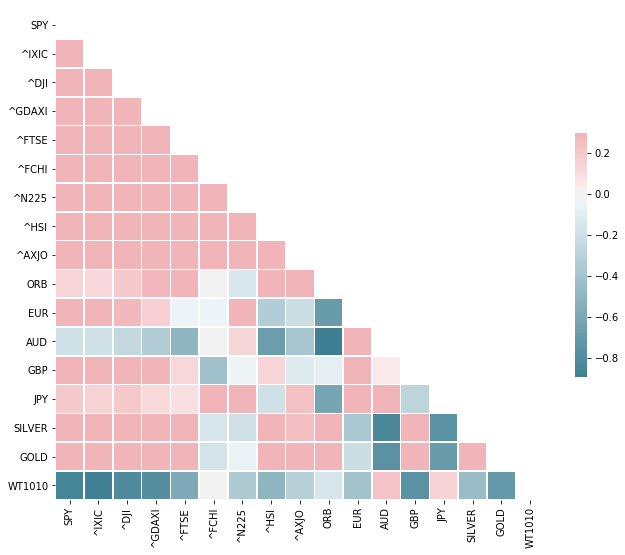

In [149]:
corr = df_index.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [150]:
df_target.tail()

,^GSPC
2016-12-23,2263.790039
2016-12-27,2268.879883
2016-12-28,2249.919922
2016-12-29,2249.260010
2016-12-30,2238.830078


In [151]:
def shift_minus(df, list_s, n):
    for symbol in list_s:
        M = pd.Series(df[symbol].shift(-1), name = str(symbol)+"-" + str(n))
        df=df.join(M)
    return df

In [152]:
df_target_2=shift_minus(df_index, indices_list_Complete,1)

In [153]:
df_target_2.drop(df_target_2.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], axis=1, inplace=True)

In [154]:
df_final=df_target.join(df_target_2)
M = pd.Series(df_target["^GSPC"].shift(-1), name = "^GSPC-" + str(1))
df_final = df_final.join(M)

In [155]:
df_final = df_final[:-1]


In [156]:
indexs=df_final.index

In [157]:
values = df_final.values
train_size = int(len(values) * 0.66)
train, test = values[0:train_size], values[train_size:len(values)]
print('Observations: %d' % (len(values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3524
Training Observations: 2325
Testing Observations: 1199


In [158]:
df_test=df_final[train_size:len(values)]

In [159]:
indexs=df_test.index

In [160]:
indexs

DatetimeIndex(['2012-03-27', '2012-03-28', '2012-03-29', '2012-03-30',
               '2012-04-02', '2012-04-03', '2012-04-04', '2012-04-05',
               '2012-04-09', '2012-04-10',
               ...
               '2016-12-15', '2016-12-16', '2016-12-19', '2016-12-20',
               '2016-12-21', '2016-12-22', '2016-12-23', '2016-12-27',
               '2016-12-28', '2016-12-29'],
              dtype='datetime64[ns]', length=1199, freq=None)

In [161]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]



In [162]:
test_y

array([1405.540039, 1403.280029, 1408.469971, ..., 2249.919922,
       2249.26001 , 2238.830078])

In [163]:
# normalize features
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
train_XS = min_max_scaler.fit_transform(train_X)
#train_yS = min_max_scaler.fit_transform(train_y)
test_XS = min_max_scaler.fit_transform(test_X)
#test_yS = min_max_scaler.fit_transform(test_y)

In [164]:
max_value = train_y.max()
min_value = train_y.min()
train_yS= (train_y - min_value) / (max_value - min_value)

In [165]:
max_value2 = test_y.max()
min_value2 = test_y.min()
test_yS= (test_y - min_value2) / (max_value2 - min_value2)

In [166]:
test_yS

array([0.12831093, 0.12603655, 0.1312595 , ..., 0.9780613 , 0.97739719,
       0.96690092])

In [167]:
train_XS = train_XS.reshape((train_XS.shape[0], 1, train_XS.shape[1]))
test_XS = test_XS.reshape((test_XS.shape[0], 1, test_XS.shape[1]))
print(train_XS.shape, train_yS.shape, test_XS.shape, test_yS.shape)

(2325, 1, 18) (2325,) (1199, 1, 18) (1199,)


In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [169]:
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_XS.shape[1], train_XS.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

In [170]:
history = model.fit(train_XS, train_yS, epochs=250, batch_size=16, validation_data=(test_XS, test_yS), verbose=2, shuffle=False)

Train on 2325 samples, validate on 1199 samples
Epoch 1/250
 - 1s - loss: 0.0667 - mean_squared_error: 0.0667 - mean_absolute_error: 0.2342 - val_loss: 0.1111 - val_mean_squared_error: 0.1111 - val_mean_absolute_error: 0.2970
Epoch 2/250
 - 0s - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1251 - val_loss: 0.1632 - val_mean_squared_error: 0.1632 - val_mean_absolute_error: 0.3310
Epoch 3/250
 - 0s - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1344 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0810
Epoch 4/250
 - 0s - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0415 - val_loss: 0.0457 - val_mean_squared_error: 0.0457 - val_mean_absolute_error: 0.1933
Epoch 5/250
 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0358 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.1024
Epoch 6/250
 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 

Epoch 45/250
 - 0s - loss: 1.5259e-04 - mean_squared_error: 1.5259e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0497
Epoch 46/250
 - 0s - loss: 1.5469e-04 - mean_squared_error: 1.5469e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0485
Epoch 47/250
 - 0s - loss: 1.5542e-04 - mean_squared_error: 1.5542e-04 - mean_absolute_error: 0.0093 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0471
Epoch 48/250
 - 0s - loss: 1.5440e-04 - mean_squared_error: 1.5440e-04 - mean_absolute_error: 0.0093 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0457
Epoch 49/250
 - 0s - loss: 1.5187e-04 - mean_squared_error: 1.5187e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0444
Epoch 50/250
 - 0s - loss: 1.4871e-04 - mean_squared_error: 1.487

Epoch 90/250
 - 0s - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0222 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0664
Epoch 91/250
 - 0s - loss: 9.3952e-04 - mean_squared_error: 9.3952e-04 - mean_absolute_error: 0.0230 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0641
Epoch 92/250
 - 0s - loss: 8.0053e-04 - mean_squared_error: 8.0053e-04 - mean_absolute_error: 0.0219 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0765
Epoch 93/250
 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0261 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0696
Epoch 94/250
 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0250 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0586
Epoch 95/250
 - 0s - loss: 9.6812e-04 - mean_squared_error: 9.6812e-04 - mean_absolute_er

Epoch 134/250
 - 0s - loss: 2.7293e-04 - mean_squared_error: 2.7293e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0503
Epoch 135/250
 - 0s - loss: 3.1743e-04 - mean_squared_error: 3.1743e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0511
Epoch 136/250
 - 0s - loss: 3.3949e-04 - mean_squared_error: 3.3949e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 137/250
 - 0s - loss: 3.6281e-04 - mean_squared_error: 3.6281e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0413
Epoch 138/250
 - 0s - loss: 4.6866e-04 - mean_squared_error: 4.6866e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - val_mean_absolute_error: 0.0429
Epoch 139/250
 - 0s - loss: 3.6686e-04 - mean_squared_error:

Epoch 178/250
 - 0s - loss: 4.8246e-04 - mean_squared_error: 4.8246e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0378
Epoch 179/250
 - 0s - loss: 6.2959e-04 - mean_squared_error: 6.2959e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0019 - val_mean_squared_error: 0.0019 - val_mean_absolute_error: 0.0365
Epoch 180/250
 - 0s - loss: 2.1929e-04 - mean_squared_error: 2.1929e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0491
Epoch 181/250
 - 0s - loss: 2.3735e-04 - mean_squared_error: 2.3735e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0495
Epoch 182/250
 - 0s - loss: 2.6570e-04 - mean_squared_error: 2.6570e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0587
Epoch 183/250
 - 0s - loss: 3.7525e-04 - mean_squared_error:

Epoch 222/250
 - 0s - loss: 1.1362e-04 - mean_squared_error: 1.1362e-04 - mean_absolute_error: 0.0082 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_absolute_error: 0.0339
Epoch 223/250
 - 0s - loss: 1.2145e-04 - mean_squared_error: 1.2145e-04 - mean_absolute_error: 0.0087 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_mean_absolute_error: 0.0318
Epoch 224/250
 - 0s - loss: 1.4554e-04 - mean_squared_error: 1.4554e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - val_mean_absolute_error: 0.0326
Epoch 225/250
 - 0s - loss: 1.2985e-04 - mean_squared_error: 1.2985e-04 - mean_absolute_error: 0.0091 - val_loss: 0.0020 - val_mean_squared_error: 0.0020 - val_mean_absolute_error: 0.0357
Epoch 226/250
 - 0s - loss: 8.7532e-05 - mean_squared_error: 8.7532e-05 - mean_absolute_error: 0.0074 - val_loss: 0.0021 - val_mean_squared_error: 0.0021 - val_mean_absolute_error: 0.0373
Epoch 227/250
 - 0s - loss: 1.0600e-04 - mean_squared_error:

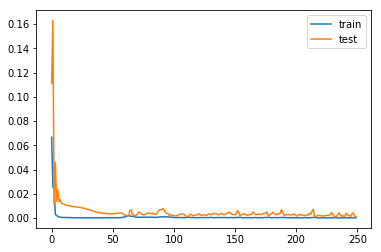

In [171]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show() 

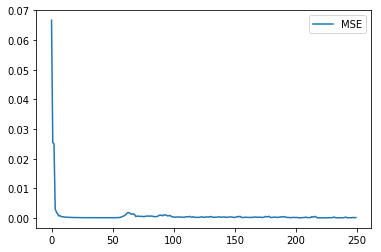

In [172]:
# plot metrics
pyplot.plot(history.history['mean_squared_error'], label='MSE')
#pyplot.plot(history.history['mean_absolute_error'],label='MAE')
pyplot.legend()
pyplot.show()

In [173]:
# make a prediction
yhat = model.predict(test_XS)
test_XS = test_XS.reshape((test_XS.shape[0], test_XS.shape[2]))

In [174]:
# invert scaling for forecast
max_value2 = test_y.max()
min_value2 = test_y.min()
inv_yhat= (yhat * (max_value2 - min_value2))+min_value2


In [175]:
inv_yhat

array([[1369.7179],
       [1367.092 ],
       [1370.883 ],
       ...,
       [2226.4854],
       [2223.3015],
       [2218.6392]], dtype=float32)

In [176]:
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 33.234


In [183]:
lowerx=inv_yhat-(2*rmse)
upperx=inv_yhat+(2*rmse)

In [184]:
inv_yhat

array([[1369.7179],
       [1367.092 ],
       [1370.883 ],
       ...,
       [2226.4854],
       [2223.3015],
       [2218.6392]], dtype=float32)

In [185]:
#upper=np.array([sp500[['Upper band']]["2017-12-01":].values]).reshape(len(sp500a),)
upper=upperx.reshape(len(inv_yhat),)
lower=lowerx.reshape(len(inv_yhat),)

In [186]:
upper.shape

(1199,)

Test RMSE: 33.234
Test R2: 0.985


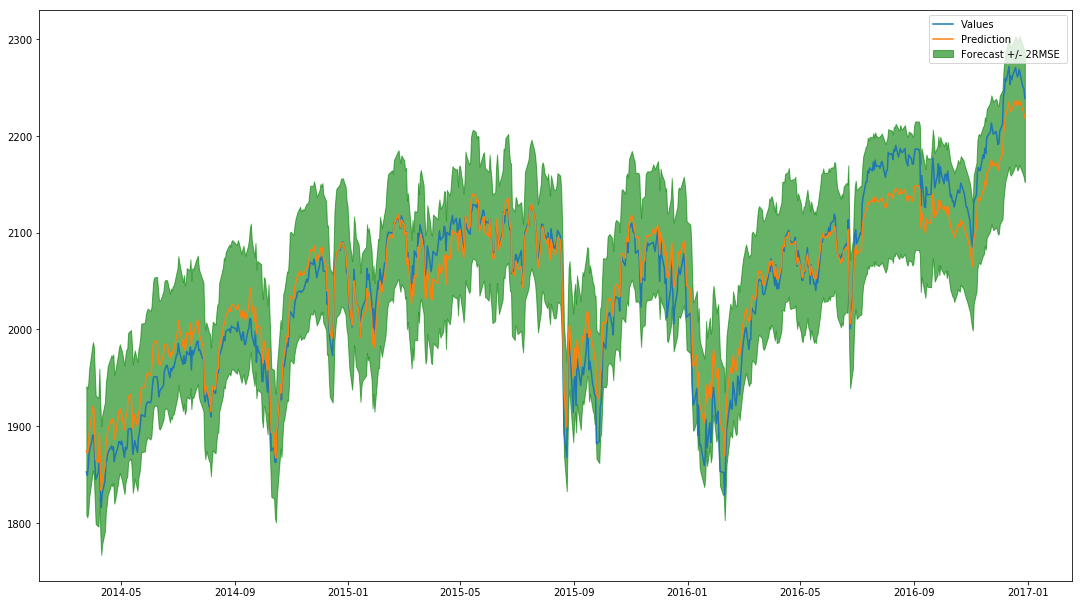

In [187]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, inv_yhat))
r2=r2_score(test_y,inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test R2: %.3f' % r2)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(18.5, 10.5, forward=True)
pyplot.plot(indexs[500:],test_y[500:], label='Values')
pyplot.plot(indexs[500:],inv_yhat[500:], label='Prediction')
pyplot.fill_between(indexs[500:],upper[500:],lower[500:], color='g', alpha=0.6, label='Forecast +/- 2RMSE ')
pyplot.legend()
pyplot.show()